In this script I go through different ways of visualizing the integrated intensity of the spectra.  The first is just straight summation of the spectra, but I also try subtracting a linear background from the spectra in order to see if that deals with the nonuniform background issue

In [1]:
from a72_utilities import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.io import imsave
from numpy.typing import ArrayLike


In [2]:
xas_data,xas_masks,xas_energies = load_registered_xas()
element_endpoints = {"Al":(76,88),"Cr":(571,581),"Fe":(703,716),"Ni":(848,864),"Ti":(452,470)}
#print(xas_energies['Cr'])


In [3]:
#TODO: incorporate a ranged background so 

# def subtract_background(image: ArrayLike, xas_energy: ArrayLike, bg_endpoints: tuple):
#     """
#     This function subtracts a linear background from a hyperspectral image array with dimensions (E, X, Y).
#     It computes the background based on two energy endpoints and subtracts it from the image.
#     Returns both the background-subtracted image and the linear background used.
    
#     Parameters:
#     - image: A 3D array (E, X, Y), where E is the energy dimension and (X, Y) are spatial dimensions.
#     - xas_energy: 1D array containing the energy values corresponding to the E dimension of the image.
#     - bg_endpoints: A tuple of two energy values (start, end) used to define the region for background calculation.
    
#     Returns:
#     - br_subtracted: The background-subtracted image.
#     - linear_br: The computed linear background.
#     """
    
#     # Get the number of energy levels (E) in the hyperspectral image
#     len_element = image.shape[0]
    
#     # Find the indices corresponding to the linear background energy range defined by bg_endpoints
#     left_index = (np.abs(xas_energy - bg_endpoints[0])).argmin()  # Index of the left endpoint
#     right_index = (np.abs(xas_energy - bg_endpoints[1])).argmin()  # Index of the right endpoint

#     # Reshape the image for easier processing; flatten X and Y dimensions into one dimension
#     reshaped = image.reshape(image.shape[0], image.shape[1] * image.shape[2]).T
    
#     # Initialize a matrix to store the linear background for each pixel
#     linear_br = np.ones(reshaped.shape)
    
#     # Loop through each pixel in the reshaped image (each row corresponds to a pixel)
#     for xy in range(len(reshaped)):
#         # Calculate the average intensity at the left and right endpoints of the background region
#         left_end = np.average(reshaped[xy, left_index:left_index+2])  # Left endpoint average
#         right_end = np.average(reshaped[xy, right_index-2:right_index])  # Right endpoint average
        
#         # Calculate the slope of the background line
#         linear_br_slope = (right_end - left_end) / len_element
        
#         # Generate the linear background for this pixel using the slope and left endpoint
#         for e in range(reshaped.shape[1]):
#             linear_br[xy, e] = linear_br_slope * e + left_end
    
#     # Transpose the linear background to match the original image shape
#     linear_br = linear_br.T
#     linear_br = linear_br.reshape(image.shape)  # Reshape back to the original (E, X, Y) shape

#     # Subtract the linear background from the original image
#     br_subtracted = image.copy() - linear_br

#     # Return the background-subtracted image and the linear background
#     return br_subtracted, linear_br
            

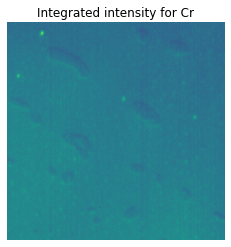

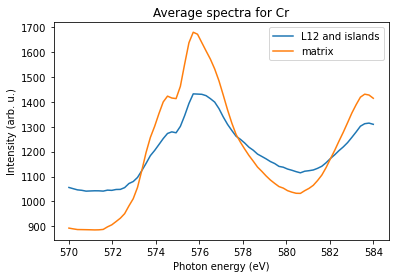

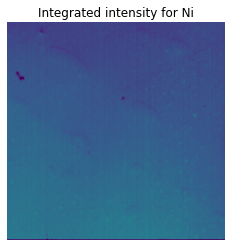

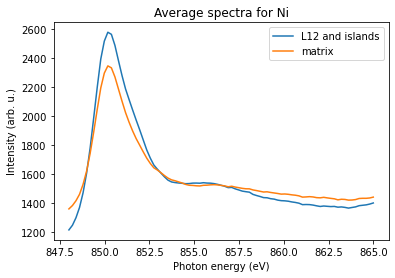

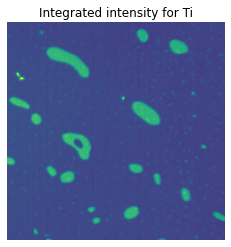

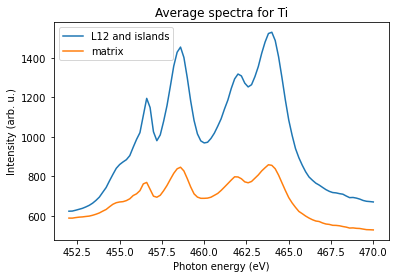

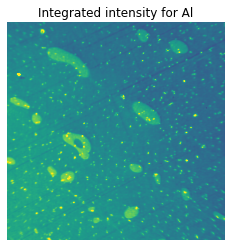

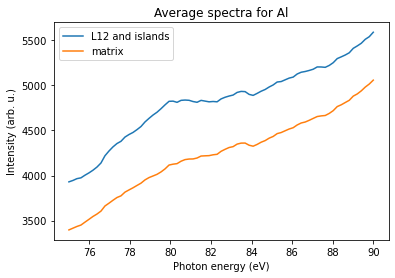

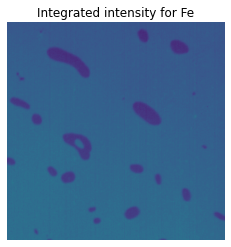

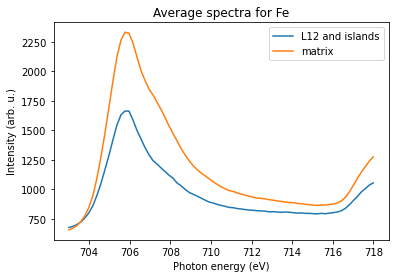

In [4]:
#plot average spectra of the matrix and l12 phases for all of the elements

for i, (element, xas) in enumerate(xas_data.items()):
    
    l12 = trim_edges(mask_subtract_arr(xas_data[element], xas_masks[element]))
    l12 = l12.astype(float)
    l12[l12 == 0.] = np.nan
    matrix = trim_edges(mask_subtract_arr(xas_data[element],np.invert(xas_masks[element])))
    matrix = matrix.astype(float)
    matrix[matrix == 0.] = np.nan
    plt.imshow(np.average(trim_edges(xas,border=30),axis=0), vmin = np.percentile(trim_edges(xas),1),vmax = np.percentile(trim_edges(xas),99))
    plt.title("Integrated intensity for " + element)
    plt.axis('off')
    plt.show()

    #plt.plot(xas_energies[element],(np.nanmean(xas,axis=(1,2))))
    plt.plot(xas_energies[element],(np.nanmean(l12,axis=(1,2))))
    plt.plot(xas_energies[element],(np.nanmean(matrix,axis=(1,2))))
    plt.xlabel("Photon energy (eV)")
    plt.ylabel("Intensity (arb. u.)")
    plt.legend(["L12 and islands","matrix"])
    plt.title("Average spectra for "+ element)
    plt.show()

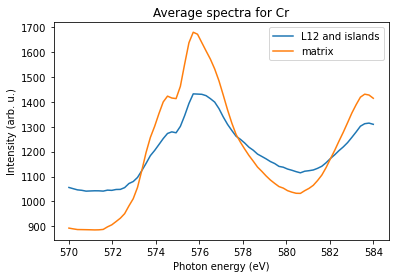

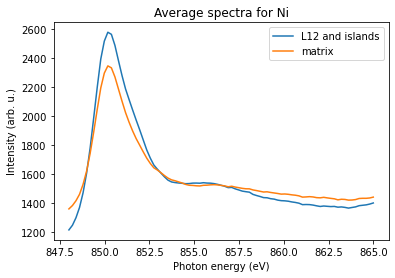

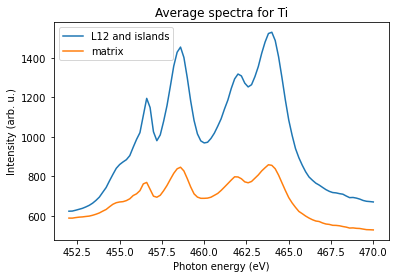

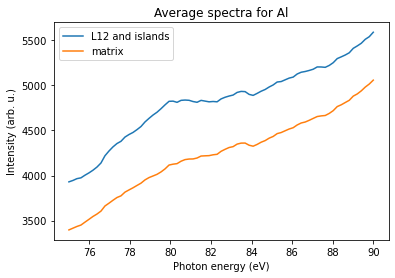

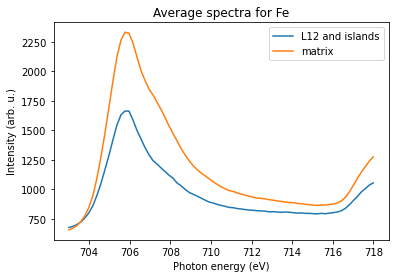

In [5]:
#Save the data from the l12 in a .csv file so it can get put into igor

average_spectra = pd.DataFrame(index=range(200))

for i, (element, xas) in enumerate(xas_data.items()):
    
    l12 = trim_edges(mask_subtract_arr(xas_data[element], xas_masks[element]))
    l12 = l12.astype(float)
    l12[l12 == 0.] = np.nan
    matrix = trim_edges(mask_subtract_arr(xas_data[element],np.invert(xas_masks[element])))
    matrix = matrix.astype(float)
    matrix[matrix == 0.] = np.nan

    average_spectra['energy_'+element] = pd.Series(xas_energies[element])
    average_spectra['intensity_'+element+'_L21'] = pd.Series(np.nanmean(l12,axis=(1,2)))
    average_spectra['intensity_'+element+'_matrix'] = pd.Series(np.nanmean(matrix,axis=(1,2)))



    plt.plot(xas_energies[element],(np.nanmean(l12,axis=(1,2))))
    plt.plot(xas_energies[element],(np.nanmean(matrix,axis=(1,2))))
    plt.xlabel("Photon energy (eV)")
    plt.ylabel("Intensity (arb. u.)")
    plt.legend(["L12 and islands","matrix"])
    plt.title("Average spectra for "+ element)
    plt.show()

average_spectra.to_csv("average_spectra.csv")

In [6]:
# test_img = xas_data["Al"]
# test_subtract, test_br = subtract_background(trim_edges(test_img,border=30))
# plt.imshow(np.sum(trim_edges(test_img,border=30),axis=0))
# plt.show()
# plt.imshow(np.sum(trim_edges(test_subtract,border=30),axis=0))
# plt.show()

The proper way to subtract the background is weird, because in some places the right edge is higher than the left edge, which shouldn't happen because absorption edges should increase monotonically

In [7]:
#plt.imshow(np.sum(test_br,axis=0))
# print(np.average(test_subtract))
# print(np.sum(test_subtract[:,10,10]))
# plt.plot(test_br[:,10,10])
# plt.plot(test_subtract[:,10,10])
# plt.plot(trim_edges(test_img,border=30)[:,10,10])
# print(np.max(np.average(test_subtract,axis=0)),np.min(np.average(test_subtract,axis=0)))

In [8]:
# test_avg = np.average(test_subtract,axis=0)
# plt.imshow(test_avg<0)
# plt.colorbar()
# plt.show()
# weird_points = trim_edges(test_img,border=30)*(test_avg<0)
# normal_points = trim_edges(test_img,border=30)*(test_avg>0)
# plt.plot(np.average(weird_points,axis=(1,2)))
# #plt.plot(np.average(normal_points,axis=(1,2)))


Cr


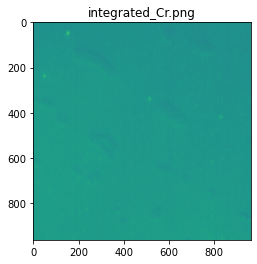

Ni


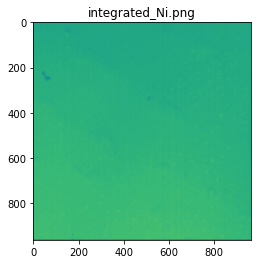

Ti


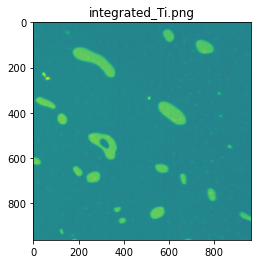

Al


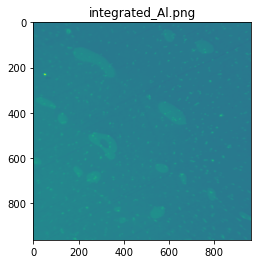

Fe


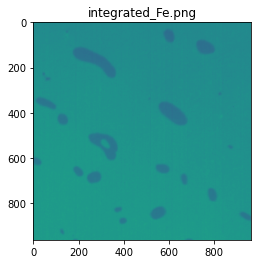

In [9]:
#Do simple summation and normalize the result for easy visualization
for (element,image) in xas_data.items():
    print(element)
    save_directory = 'results'
    filename = "integrated_"+element+'.png'
    integrated_image = np.average(image,axis=(0))
    plt.imshow(integrated_image[30:-30,30:-30])
    plt.title("integrated_"+str(element)+'.png')
    plt.show()
    imsave(os.path.join(save_directory,filename),make_16bit(integrated_image[30:-30,30:-30]))
    

Cr


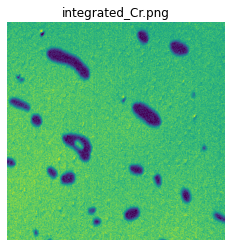

<ipython-input-10-f814a43a36cc>:28: UserWarning: results/subtracted_background_Cr.png is a low contrast image
  imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))


Ni


KeyboardInterrupt: 

In [10]:
for (element,image) in xas_data.items():
    print(element)
    energy_list = xas_energies[element]

    #Set up the filenames and directory where the images will be saved
    save_directory = 'results'
    filename = "subtracted_integrated_"+element+'.png'
    br_filename = "subtracted_background_"+element+'.png'


    subtracted_img, br = subtract_background(trim_edges(image,border=30),energy_list,element_endpoints[element])
    integrated_image = np.sum(subtracted_img,axis=(0))
    #deal with values that are too big or too small and lead to weird behavior
    integrated_image[integrated_image <=1 ] = 1.
    integrated_image[integrated_image >=65535] = 65535

    vmin = np.percentile(integrated_image, 1)
    vmax = np.percentile(integrated_image, 99)
    # Display the image using the 1st and 99th percentiles for intensity scaling
    plt.imshow(integrated_image, vmin=vmin, vmax=vmax)

    plt.title("integrated_"+str(element)+'.png')
    plt.axis("off")
    plt.show()

    #specifically don't normalize the array to keep the intensity information
    imsave(os.path.join(save_directory,filename),np.uint16(integrated_image))
    imsave(os.path.join(save_directory,br_filename),np.uint16(np.average(br,axis=0)))